In [144]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random

warnings.filterwarnings('ignore')

In [145]:
kerasModels = {
    'mlp': 'serialized/keras/mlpModel.keras',
    'lstm': 'serialized/keras/lstmModel.keras',
    'dnn': 'serialized/keras/dnnModel.keras'
}

# Loading a serialized model
model = load_model(kerasModels['mlp'])

In [146]:
# New dataset for forecasting
data = {
    'Location': random.choices(['CityA', 'CityB', 'CityC'], k=130),
    'Year': [2023] * 130,
    'Month': random.choices(range(1, 13), k=130),
    'Day': random.choices(range(1, 29), k=130),  # To avoid February issues
    'Hour': random.choices(range(0, 24), k=130),
    'PM2.5': [round(random.uniform(10, 300), 2) for _ in range(130)],
    'PM10': [round(random.uniform(20, 400), 2) for _ in range(130)],
    'O3': [round(random.uniform(5, 150), 2) for _ in range(130)],
    'CO': [round(random.uniform(0.1, 10), 2) for _ in range(130)],
    'SO2': [round(random.uniform(0.5, 50), 2) for _ in range(130)],
    'NO2': [round(random.uniform(1, 100), 2) for _ in range(130)],
}

data = pd.DataFrame(data)
data.head()

,Location,Year,Month,Day,Hour,PM2.5,PM10,O3,CO,SO2,NO2
0,CityA,2023,10,12,13,121.51,194.26,56.48,9.35,28.53,31.58
1,CityB,2023,3,20,1,207.76,365.72,142.72,6.00,20.45,16.74
2,CityA,2023,4,9,16,248.37,236.63,39.55,1.88,5.18,97.72
3,CityA,2023,8,17,1,170.57,270.50,5.58,3.03,43.31,8.93
4,CityB,2023,9,3,8,223.58,280.46,65.57,6.12,43.04,31.81


In [147]:
# Label encoding
le = LabelEncoder()
data['LocationNumeric'] = le.fit_transform(data['Location'])
data['Hour'] = le.fit_transform(data['Hour'])

# Convert hours to numeric format
data['Hour'] = data['Hour'].astype(str).str.split(":").str[0].astype(int)

# Feature selection
X_new = data[['LocationNumeric', 'Year', 'Month', 'Day', 'Hour', 'PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'NO2']]

In [148]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,869 (519.02 KB)

 Trainable params: 44,289 (173.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 88,580 (346.02 KB)

None


In [149]:
# Data scaling (as in the training model)
scaler = MinMaxScaler()
X_new_scaled = scaler.fit_transform(X_new)

In [150]:
# Prognostication
#X_new_scaled = np.expand_dims(X_new_scaled, axis=1) # LSTM only!!!
predictions = model.predict(X_new_scaled)

df_full = X_new.copy()
df_full['AQI'] = predictions
print("Input data:")
print(df_full)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Input data:
     LocationNumeric  Year  Month  Day  Hour   PM2.5    PM10      O3    CO  \
0                  0  2023     10   12    13  121.51  194.26   56.48  9.35   
1                  1  2023      3   20     1  207.76  365.72  142.72  6.00   
2                  0  2023      4    9    16  248.37  236.63   39.55  1.88   
3                  0  2023      8   17     1  170.57  270.50    5.58  3.03   
4                  1  2023      9    3     8  223.58  280.46   65.57  6.12   
..               ...   ...    ...  ...   ...     ...     ...     ...   ...   
125                0  2023      1   20    13  139.90  107.71    9.35  6.69   
126                0  2023      8    7    16   56.74  340.24    6.03  4.87   
127                2  2023     10   24    10  131.53   34.76  118.78  7.02   
128                2  2023      8    9    14  204.29   37.76   66.00  5.97   
129                2  2023     11   26     3  299.99   78.10   85.83  5.24   

       SO2   

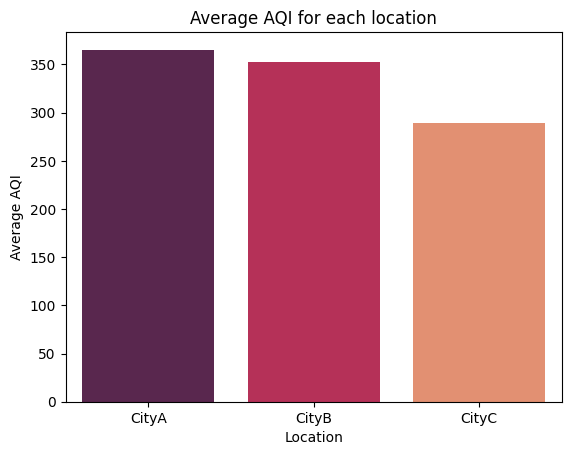

In [151]:
# --- 1. Analysis by location ---
# Average AQI for each location
df_full['Location'] = data['Location']
location_aqi = df_full.groupby('Location')['AQI'].mean().reset_index()
sns.barplot(data=location_aqi, x='Location', y='AQI', palette='rocket')
plt.title('Average AQI for each location')
plt.xlabel('Location')
plt.ylabel('Average AQI')
plt.show()

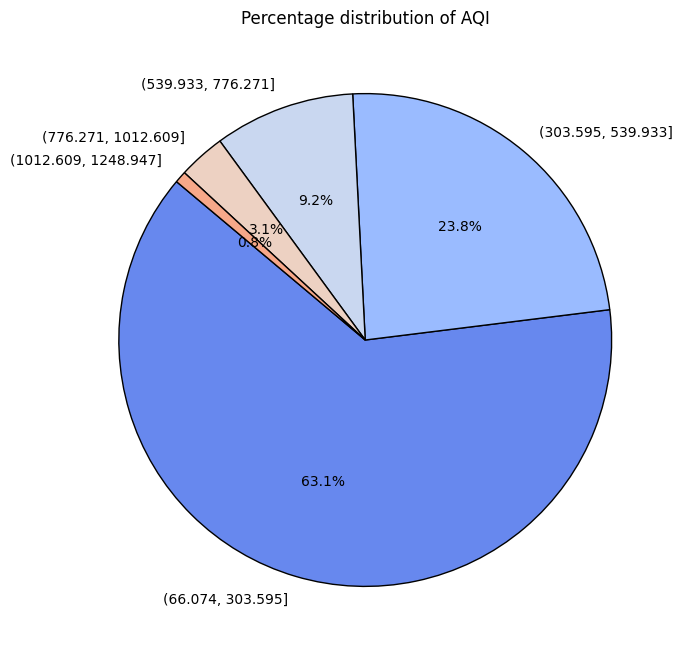

In [152]:
# --- 2. Grouping data by AQI ---
aqi_class_distribution = df_full['AQI'].value_counts(bins=5)

# Побудова кругової діаграми
plt.figure(figsize=(8, 8))
aqi_class_distribution.plot.pie(
    autopct='%1.1f%%', 
    startangle=140, 
    colors=sns.color_palette('coolwarm'),
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Percentage distribution of AQI')
plt.ylabel('')  # Remove the Y axis label
plt.show()

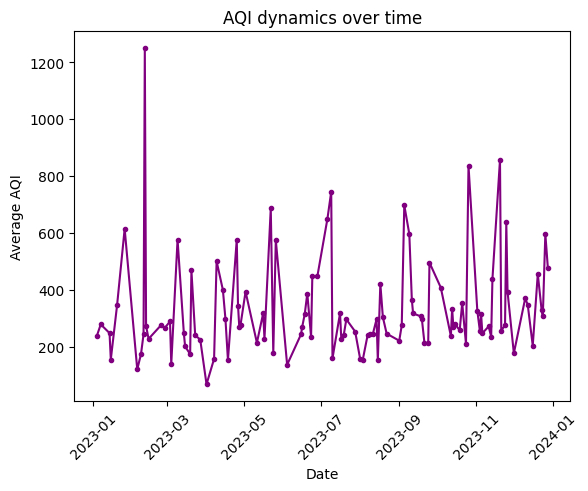

In [153]:
# --- 3. Time Analysis ---
# Line graph of AQI changes over time
df_full['Date'] = pd.to_datetime(df_full[['Year', 'Month', 'Day']])
time_aqi = df_full.groupby('Date')['AQI'].mean().reset_index()
plt.plot(time_aqi['Date'], time_aqi['AQI'], marker='.', linestyle='-', color='purple')
plt.title('AQI dynamics over time')
plt.xlabel('Date')
plt.ylabel('Average AQI')
plt.xticks(rotation=45)
plt.show()

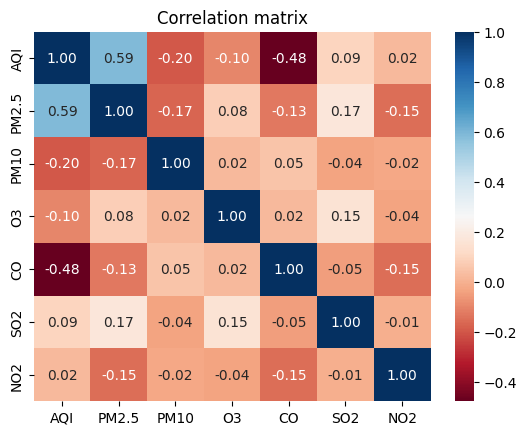

In [154]:
# --- 4. Correlation between variables ---
# Correlation matrix
corr_matrix = df_full[['AQI', 'PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'NO2']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', fmt=".2f")
plt.title('Correlation matrix')
plt.show()